In [111]:
import re
from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
import pandas as pd

notebook = Shell.map_filename("~/cm/cloudmesh_mllog.log").path

mynotebook = readfile(notebook)
list_of_mllogs = []

count_lines = 0
for line in mynotebook.splitlines():
    #line.replace('\\', '')
    if 'F=' in line and 'S=' in line and 'E=' in line and 'NNSE' in line:
        list_of_mllogs.append(line)
        count_lines += 1
        print(line)

print(count_lines)

:::MLLOG {"namespace": "cloudmesh", "time_ms": 1668027247664, "event_type": "POINT_IN_TIME", "key": "RunTFTCustomVersion DLResults Graph Title event_num:0", "value": "{'extrastring': 'Training 0.72242 11/09/2022, 15:54:02 UTC EARTHQ-newTFTv29 Length=1775, Location Summed Results Magnitude 2 weeks Now, AVG MSE F=0.003839 S=0.003048 E=0.00478 TOTAL summedErr/SummedObs 50.68% NNSE  A:0.481 AT:0.48 S:0.313 ST:0.3'}", "metadata": {"file": "/tmp/ipykernel_123144/3089554875.py", "lineno": 214}}
:::MLLOG {"namespace": "cloudmesh", "time_ms": 1668027247721, "event_type": "POINT_IN_TIME", "key": "RunTFTCustomVersion DLResults Graph Title event_num:1", "value": "{'extrastring': 'Validation 0.74745 11/09/2022, 15:54:02 UTC EARTHQ-newTFTv29 Length=1775, Location Summed Results Magnitude 2 weeks Now, AVG MSE F=0.004157 S=0.003404 E=0.005054 TOTAL summedErr/SummedObs 47.01% NNSE  A:0.481 AT:0.48 S:0.313 ST:0.3'}", "metadata": {"file": "/tmp/ipykernel_123144/3089554875.py", "lineno": 214}}
:::MLLOG {"

In [112]:
fixed_dicts = []
for mllog in list_of_mllogs:
    working_line = mllog.strip()
    # print(type(working_line))
    # print(working_line)
    working_line = working_line.replace(':::MLLOG ', '')
    # print('a', working_line)
    working_line = working_line[:-3]
    # print('b', working_line)
    working_line = working_line.replace('\\', '')
    # print('c', working_line)
    working_line = working_line.split(', "metadata":', 1)[0]
    working_line += '}'
    working_line = eval(working_line)
    working_line['value'] = eval(working_line['value'])
    # print('d', working_line)
    # print(type(working_line))

    # interpreting scientific values
    parse_line = working_line['value']['extrastring']
    parse_list = parse_line.split()

    # this function returns the value after a specified word
    def looking_for(seeking_value: str):
        found_it = False
        for word in parse_list:
            if found_it:
                return word
            if word == seeking_value:
                found_it = True
                continue

    validation_value = looking_for('Validation')
    if validation_value:
        working_line['value']['validation'] = validation_value
    training_value = looking_for('Training')
    if training_value:
        working_line['value']['training'] = training_value

    list_of_values = []
    working_line['value']['MSE'] = {}
    for word in parse_list:
        if '=' in word and ('F' in word or 'S' in word or 'E' in word):
            temp_word = word.split('=')
            working_line['value']['MSE'][temp_word[0]] = temp_word[1]
        elif 'A:' in word or 'AV:' in word or 'S:' in word or 'SV:' in word:
            temp_word = word.split(':')
            working_line['value'][temp_word[0]] = temp_word[1]
        elif 'A:' in word or 'AT:' in word or 'S:' in word or 'ST:' in word:
            temp_word = word.split(':')
            working_line['value'][temp_word[0]] = temp_word[1]
    working_line['value']['title'] = working_line['key']
    working_line['key'] = 'result'

    program_title = looking_for('UTC')
    working_line['value']['program'] = program_title
    nnse = looking_for('summedErr/SummedObs')
    working_line['value']['NNSE'] = nnse
    comment = looking_for('TOTAL')
    working_line['value']['comment'] = comment

    future = re.search('FUTURE (.*) MSE', working_line['value']['extrastring'])
    try:
        working_line['value']['future'] = future.group(1)
    except AttributeError:
        pass

    loc_sum = re.search('Location Summed Results (.*),', working_line['value']['extrastring'])
    working_line['value']['location_summed_results'] = loc_sum.group(1)
    del working_line['value']['extrastring']

    fixed_dicts.append(working_line)


In [113]:
from pprint import pprint
for fixed_dict in fixed_dicts:
    pprint(fixed_dict)
print(len(fixed_dicts))
    # print(working_line)


{'event_type': 'POINT_IN_TIME',
 'key': 'result',
 'namespace': 'cloudmesh',
 'time_ms': 1668027247664,
 'value': {'A': '0.481',
           'AT': '0.48',
           'MSE': {'E': '0.00478', 'F': '0.003839', 'S': '0.003048'},
           'NNSE': '50.68%',
           'S': '0.313',
           'ST': '0.3',
           'comment': 'summedErr/SummedObs',
           'location_summed_results': 'Magnitude 2 weeks Now',
           'program': 'EARTHQ-newTFTv29',
           'title': 'RunTFTCustomVersion DLResults Graph Title event_num:0',
           'training': '0.72242'}}
{'event_type': 'POINT_IN_TIME',
 'key': 'result',
 'namespace': 'cloudmesh',
 'time_ms': 1668027247721,
 'value': {'A': '0.481',
           'AT': '0.48',
           'MSE': {'E': '0.005054', 'F': '0.004157', 'S': '0.003404'},
           'NNSE': '47.01%',
           'S': '0.313',
           'ST': '0.3',
           'comment': 'summedErr/SummedObs',
           'location_summed_results': 'Magnitude 2 weeks Now',
           'program': 'EA

In [114]:
list_of_value_dicts_training = []
list_of_value_dicts_validation = []
fails = 0
for dictionary in fixed_dicts:
    # try:
    #     if dictionary['value']['training']:
    #         list_of_value_dicts_training.append(dictionary['value'])
    # except KeyError:
    #     list_of_value_dicts_validation.append(dictionary['value'])
    if dictionary.get('value', None).get('training', None):
        list_of_value_dicts_training.append(dictionary['value'])
    elif dictionary.get('value', None).get('validation', None):
        list_of_value_dicts_validation.append(dictionary['value'])
    else:
        fails += 1
print('fails:', fails)
    #list_of_value_dicts.append(dictionary['value'])

for iterated_dictionary in list_of_value_dicts_training:
    temp_mse = iterated_dictionary['MSE']
    iterated_dictionary['F'] = temp_mse['F']
    iterated_dictionary['S'] = temp_mse['S']
    iterated_dictionary['E'] = temp_mse['E']

for iterated_dictionary in list_of_value_dicts_validation:
    temp_mse = iterated_dictionary['MSE']
    iterated_dictionary['F'] = temp_mse['F']
    iterated_dictionary['S'] = temp_mse['S']
    iterated_dictionary['E'] = temp_mse['E']



fails: 0


In [115]:
df_training = pd.DataFrame(list_of_value_dicts_training)
df_validation = pd.DataFrame(list_of_value_dicts_validation)

df_training.drop('MSE', axis=1, inplace=True)
df_validation.drop('MSE', axis=1, inplace=True)

In [116]:
display(df_training)

,training,A,AT,S,ST,title,program,NNSE,comment,location_summed_results,F,E,AV,SV,future
0,0.72242,0.481,0.48,0.003048,0.3,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,50.68%,summedErr/SummedObs,Magnitude 2 weeks Now,0.003839,0.00478,NaN,NaN,NaN
1,0.72242,0.481,NaN,0.005797,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.3%,summedErr/SummedObs,Mag 3 Months Back,0.005381,0.004886,0.484,0.375,NaN
2,0.72242,0.582,0.581,0.006474,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.16%,summedErr/SummedObs,Mag 6 Months Back,0.005805,0.005009,NaN,NaN,NaN
3,0.72242,0.582,NaN,0.008627,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.13%,summedErr/SummedObs,Mag Year Back,0.007831,0.006883,0.587,0.636,NaN
4,0.72242,0.481,0.48,0.002973,0.3,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,40.56%,summedErr/SummedObs,Magnitude 2 weeks Now,0.003634,0.004427,NaN,NaN,Magnitude 2 weeks Now 2wk+7AVG
5,0.72242,0.481,NaN,0.00718,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,24.3%,summedErr/SummedObs,Mag 3 Months Back,0.006861,0.006479,0.484,0.375,Mag 3 Months Back 2wk+7AVG
6,0.72242,0.582,0.581,0.007617,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.27%,summedErr/SummedObs,Mag 6 Months Back,0.006939,0.006126,NaN,NaN,Mag 6 Months Back 2wk+7AVG
7,0.72242,0.582,NaN,0.008635,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.58%,summedErr/SummedObs,Mag Year Back,0.008419,0.00816,0.587,0.636,Mag Year Back 2wk+7AVG
8,0.72242,0.481,0.48,0.00309,0.3,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,42.99%,summedErr/SummedObs,Magnitude 2 weeks Now,0.003766,0.004582,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG
9,0.72242,0.481,NaN,0.007452,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,27.88%,summedErr/SummedObs,Mag 3 Months Back,0.007153,0.00679,0.484,0.375,Mag 3 Months Back 2wk+13AVG


In [117]:
display(df_validation)

,validation,A,AT,S,ST,title,program,NNSE,comment,location_summed_results,F,E,AV,SV,future
0,0.74745,0.481,0.48,0.003404,0.3,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,47.01%,summedErr/SummedObs,Magnitude 2 weeks Now,0.004157,0.005054,NaN,NaN,NaN
1,0.74745,0.481,NaN,0.006075,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,21.97%,summedErr/SummedObs,Mag 3 Months Back,0.005441,0.004686,0.484,0.375,NaN
2,0.74745,0.582,0.581,0.006831,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.1%,summedErr/SummedObs,Mag 6 Months Back,0.005979,0.004965,NaN,NaN,NaN
3,0.74745,0.582,NaN,0.009206,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.45%,summedErr/SummedObs,Mag Year Back,0.008337,0.007302,0.587,0.636,NaN
4,0.74745,0.481,0.48,0.003287,0.3,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,37.97%,summedErr/SummedObs,Magnitude 2 weeks Now,0.003884,0.004601,NaN,NaN,Magnitude 2 weeks Now 2wk+7AVG
5,0.74745,0.481,NaN,0.007471,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,22.89%,summedErr/SummedObs,Mag 3 Months Back,0.006845,0.006093,0.484,0.375,Mag 3 Months Back 2wk+7AVG
6,0.74745,0.582,0.581,0.007894,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.52%,summedErr/SummedObs,Mag 6 Months Back,0.007081,0.006105,NaN,NaN,Mag 6 Months Back 2wk+7AVG
7,0.74745,0.582,NaN,0.009297,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,24.95%,summedErr/SummedObs,Mag Year Back,0.009429,0.009587,0.587,0.636,Mag Year Back 2wk+7AVG
8,0.74745,0.481,0.48,0.003432,0.3,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,41.27%,summedErr/SummedObs,Magnitude 2 weeks Now,0.004054,0.004806,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG
9,0.74745,0.481,NaN,0.007723,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,26.62%,summedErr/SummedObs,Mag 3 Months Back,0.007138,0.006431,0.484,0.375,Mag 3 Months Back 2wk+13AVG


In [118]:
mynotebook = readfile(notebook)
list_of_mllogs = []

count_lines = 0
for line in mynotebook.splitlines():
    #line.replace('\\', '')
    if 'MSE Full' in line and 'MSE Start' in line:
        list_of_mllogs.append(line)
        count_lines += 1
        print(line)

print(count_lines)

:::MLLOG {"namespace": "cloudmesh", "time_ms": 1668027074249, "event_type": "POINT_IN_TIME", "key": "result", "value": "{'result': True, 'RunTFTCustomVersion MSE': 0, 'MSE_event_num': 0, 'i': 0, 'name': 'Next Magnitude 2 weeks Now', 'IndE^2/IndObs^2': 87.88, 'IndE/IndObs': 122.78, 'summedErr/SummedObs': 49.22, 'line': ' AVG MSE  All Time Full 0.003902 Start Full 0.003119 End Full 0.004835 All Time TRAIN 0.003839 VAL 0.004157 Start TRAIN 0.003048 VAL 0.003404 End TRAIN 0.00478 VAL 0.005054', 'MSE Full': 0.003839, 'MSE Start': 0.003048, 'MSE End': 0.00478, 'MSE Total': '47.01%'}", "metadata": {"file": "/tmp/ipykernel_123144/749521477.py", "lineno": 240}}
:::MLLOG {"namespace": "cloudmesh", "time_ms": 1668027074260, "event_type": "POINT_IN_TIME", "key": "result", "value": "{'result': True, 'RunTFTCustomVersion MSE': 1, 'MSE_event_num': 1, 'i': 1, 'name': 'Next Mag 3 Months Back', 'IndE^2/IndObs^2': 64.55, 'IndE/IndObs': 71.19, 'summedErr/SummedObs': 22.67, 'line': ' AVG MSE  All Time Full

In [119]:
fixed_dicts = []
list_of_dicts_of_values = []
for mllog in list_of_mllogs:
    working_line = mllog.strip()
    # print(type(working_line))
    # print(working_line)
    working_line = working_line.replace(':::MLLOG ', '')
    # print('a', working_line)
    working_line = working_line[:-3]
    # print('b', working_line)
    working_line = working_line.replace('\\', '')
    # print('c', working_line)
    working_line = working_line.split(', "metadata":', 1)[0]
    working_line += '}'
    working_line = eval(working_line)
    working_line['value'] = eval(working_line['value'])
    list_of_dicts_of_values.append(working_line['value'])


In [120]:
df_mse = pd.DataFrame(list_of_dicts_of_values)

In [121]:
display(df_mse)

,result,RunTFTCustomVersion MSE,MSE_event_num,i,name,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,line,MSE Full,MSE Start,MSE End,MSE Total
0,True,0,0,0,Next Magnitude 2 weeks Now,87.88,122.78,49.22,AVG MSE All Time Full 0.003902 Start Full 0....,0.003839,0.003048,0.004780,47.01%
1,True,1,1,1,Next Mag 3 Months Back,64.55,71.19,22.67,AVG MSE All Time Full 0.005393 Start Full 0....,0.005381,0.005797,0.004886,21.97%
2,True,2,2,2,Next Mag 6 Months Back,58.29,61.35,19.95,AVG MSE All Time Full 0.00584 Start Full 0.0...,0.005805,0.006474,0.005009,20.1%
3,True,3,3,3,Next Mag Year Back,58.17,62.45,19.33,AVG MSE All Time Full 0.007932 Start Full 0....,0.007831,0.008627,0.006883,20.45%
4,True,4,4,4,Magnitude 2 weeks Now 2wk+2,85.84,112.55,45.42,AVG MSE All Time Full 0.003725 Start Full 0....,0.003669,0.002936,0.004543,43.23%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,True,99,99,99,Mag Year Back 2wk+25,70.96,79.86,25.21,AVG MSE All Time Full 0.011817 Start Full 0....,0.011721,0.012587,0.010657,26.63%
100,True,100,100,100,Magnitude 2 weeks Now 2wk+26,88.41,109.58,51.20,AVG MSE All Time Full 0.003968 Start Full 0....,0.003904,0.003166,0.004811,50.23%
101,True,101,101,101,Mag 3 Months Back 2wk+26,75.29,82.31,30.00,AVG MSE All Time Full 0.007335 Start Full 0....,0.007344,0.007491,0.007164,29.58%
102,True,102,102,102,Mag 6 Months Back 2wk+26,72.63,81.70,25.31,AVG MSE All Time Full 0.009062 Start Full 0....,0.009043,0.009572,0.008392,26.44%


<AxesSubplot: xlabel='index', ylabel='MSE Full'>

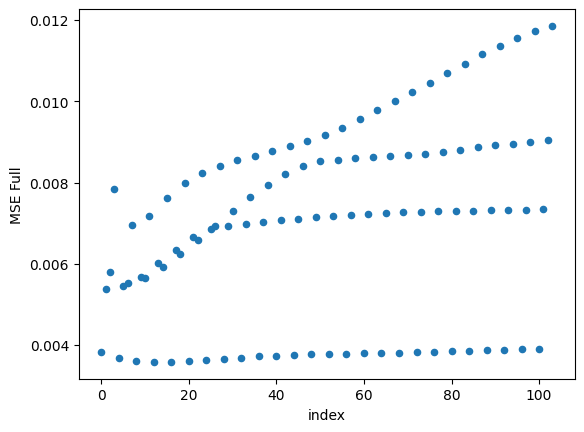

In [124]:
df_mse.reset_index().plot.scatter(x='index', y='MSE Full')